In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
plt.style.use('ggplot')

from astropy.table import Table

In [2]:
def export_legend(legend, filename= 'legend.png', expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi = 300, bbox_inches = bbox)

def plotPerformace(experimentDictionary, experiment = 'blinks', comment = '', preprocessing = [], classifier = [], saveFig = False, sort = False, fltr = None, title = None):
    plt.figure(1)
    i = 0

    #markers = ['x', 'o', 'v']
    markers = {'None': 'x', '-': 'x', 'CQ, norm.': 'o', 'CQ, norm., drop chs.': 'v',
               'CQ, norm., drop chs., ICA': 'p', 'CQ, norm., drop chs., ICA, reject': 'D', 'CQ, norm., ICA, reject': '2',
               'CQ, norm., ICA, reject': '*', 'CQ, norm., ICA': '+', 'CQ, norm., ICA, reject, denoised': '^',
               'CQ, norm., ICA, reject, Fourier': '<', 'CQ, norm., ICA, denoised': 's', 'CQ, norm., ICA, Fourier': '>',
               'CQ, norm., ICA, reject, filtr.': 'H', 'CQ, norm., ICA, filtr.': 'h', 'CQ, norm., ICA': '|'}
    colors = {'Bayes': 'b', 'Percp. A': 'g', 'Percp. B': 'r', 'CNN C': 'c', 'CNN D': 'm',
              'CNN E': 'k', 'CNN F': 'orange', 'CNN G': 'tab:purple', 'CNN H': 'sienna'}
    font = font_manager.FontProperties(family='Consolas')#, weight = 'bold')

    key = lambda i: (i['classifier'][0] != 'B', i['classifier'].replace('*', '')[-1], i['preprocessing'])
    if sort:
        key = lambda i: (i[sort], i['classifier'][0] != 'B', i['classifier'].replace('*', '')[-1], i['preprocessing'])
    
    defaultFilter = lambda i: i
    if fltr == None:
        fltr = defaultFilter
    
    length = 0
    for performance in sorted(filter(fltr, experimentDictionary), key = key):
        if (not len(preprocessing) or performance['preprocessing'] in preprocessing) and len(performance['preprocessing']) > length:
            length = len(performance['preprocessing']) + 2
    
    for performance in sorted(filter(fltr, experimentDictionary), key = key):
        color = colors[performance['classifier'].replace('*', '')]
        label = f"Pre procss: {str(performance['preprocessing']):<{length}}| Clsfr: {performance['classifier']:<9}|{performance['specifier']:<}"
        marker = markers[performance['preprocessing']]
        if (not len(preprocessing) or performance['preprocessing'] in preprocessing) and (not len(classifier) or performance['classifier'].replace('*', '') in classifier):
            plt.plot(i, performance['accuracy'], marker = marker, color = color, label = label, linestyle = 'None')
            plt.errorbar(i, performance['accuracy'], yerr = performance['accuracy-error'], color = color, alpha = 0.5)#, marker = marker, label = label)
            i+= 1
        if experiment == 'hands' and fltr != None:
            classes = performance['classes']
    plt.ylabel('accuracy (in %)')
    plt.ylim(0,100)
    legend = plt.legend(bbox_to_anchor=(1.04, 0.5), loc= 'center left', prop = font)
    plt.xticks([])
    if not title:
        title = f'Performance of the {experiment} experiment'
        if experiment == 'hands' and fltr != defaultFilter:
            title += f', classes: {classes}'
    plt.title(title, size = 'medium')
    if saveFig:
        export_legend(legend, filename = f'{experiment}-preprocessing-{preprocessing}-classifier-{classifier}-{comment}-legend.png')
        legend.remove()
        plt.savefig(f'{experiment}-preprocessing-{preprocessing}-classifier-{classifier}-{comment}-accuracyData.png', dpi = 300)
        plt.legend(bbox_to_anchor=(1.04, 0.5), loc= 'center left', prop = font)
    plt.show()
    plt.close()

    plt.figure(2)
    i = 0
    
    for performance in sorted(filter(fltr, experimentDictionary), key = key):
        color = colors[performance['classifier'].replace('*', '')]
        label = f"Pre procss: {str(performance['preprocessing']):<{length}}| Clsfr: {performance['classifier']:<9}|{performance['specifier']:<}"
        marker = markers[performance['preprocessing']]
        if (not len(preprocessing) or performance['preprocessing'] in preprocessing) and (not len(classifier) or performance['classifier'].replace('*', '') in classifier):
            plt.plot(i, performance['mcc'], marker = marker, color = color, label = label, linestyle = 'None')
            plt.errorbar(i, performance['mcc'], yerr = performance['mcc-error'], color = color, alpha = 0.5)#, marker = marker, label = label)
            i+= 1
    plt.ylabel('MCC')
    plt.ylim(-0.5, 1)
    plt.xticks([])
    if not title:
        title = f'Performance of the {experiment} experiment'
        if experiment == 'hands' and fltr != defaultFilter:
            title += f', classes: {classes}'
    plt.title(title, size = 'medium')
    if saveFig:
        plt.savefig(f'{experiment}-preprocessing-{preprocessing}-classifier-{classifier}-{comment}-MCCData.png', dpi = 300)
    plt.show()
    plt.close()

In [37]:
directory = os.fsencode('floats')

results = {}
results['Blinks'] = []
results['Hands'] = []
results['Hands-small'] =[]
results['Light'] = []
results['Music'] = []
results['Beeps'] = []

#results is a dictionary of lists (corresponding to the experiments)
#lists of dictionaries with keys: 'specifier', 'classefier', 'preprocessing', accuracy', 'accuracy-err', 'mcc', 'mcc-err'
#specifier is 'classes' or 'window'

specifiers = {
    '\\textit{blink}, \\textit{blank}': 'blink, blank',
    '\\textit{left}, \\textit{right}, \\textit{blank}': 'left, right, blank',
    '\\textit{left}, \\textit{right}': 'left, right',
    '\\textit{move}, \\textit{blank}': 'move, blank',
}

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.tex') and 'app' in filename:
        tab = Table.read('floats/' + filename)
        colnames = tab[0].colnames
        for row in tab:
            results[row[0]].append({})
            results[row[0]][-1]['specifier'] = row[1]
            if len(row[1]) > 8:
                results[row[0]][-1]['specifier'] = specifiers[row[1]]
            preprocessing = row[2].replace('\\scriptsize{', '')
            preprocessing = preprocessing.replace('}', '')
            preprocessing = preprocessing.replace('+ ICA', 'CQ, norm., drop chs., ICA')
            results[row[0]][-1]['preprocessing'] = preprocessing
            results[row[0]][-1]['classifier'] = row[3]
            results[row[0]][-1]['accuracy'] = np.float64(row[4][1:row[4].index('\pm')])
            results[row[0]][-1]['accuracy-error'] = np.float64(row[4][row[4].index('\pm') + 3 : -3])
            results[row[0]][-1]['mcc'] = np.float64(row[5][1:row[5].index('\pm')])
            results[row[0]][-1]['mcc-error'] = np.float64(row[5][row[5].index('\pm') + 3 : -1])
            
#remove duplicates
for experiment in results:
    results[experiment] = [i for n, i in enumerate(results[experiment]) if i not in results[experiment][n + 1:]]

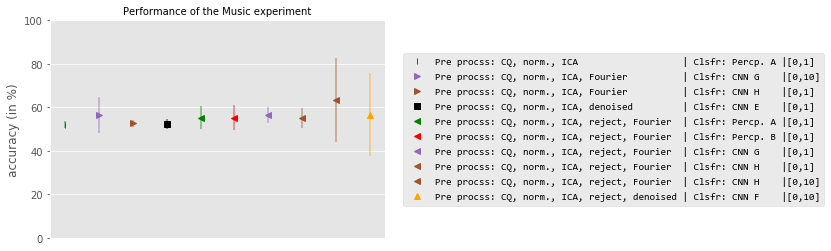

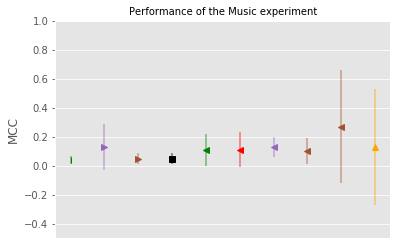

In [85]:
fltr = lambda i: i['classes'] == 'left, right'

leftright = lambda i: i['classes'] == 'left, right'
leftrightblank = lambda i: i['classes'] == 'left, right, blank'
moveblank = lambda i: i['classes'] == 'move, blank'

mccTreshold = lambda i: (i['mcc'] > 0.1) or (i['mcc'] - i['mcc-error'] > 0)
accTreshold = lambda i: i['accuracy'] - i['accuracy-error'] > 50

#plotPerformace(hands, 'hands', saveFig = True, fltr = leftrightblank, comment = 'leftrightblank')
#plotPerformace(hands, 'hands', saveFig = True, fltr = leftright, comment = 'leftright')
#plotPerformace(handsSmall, 'hands', saveFig = True, comment = 'small-leftright')
#plotPerformace(hands, 'hands', saveFig = True, fltr = moveblank, comment = 'moveblank')

experiment = 'Music'
plotPerformace(results[experiment], experiment, saveFig = True, fltr = mccTreshold, comment = '', sort = 'preprocessing')#, classifier = ['CNN G', 'CNN H'])#, preprocessing = ['CQ, norm., ICA', 'CQ, norm., ICA, reject'])

No handles with labels found to put in legend.


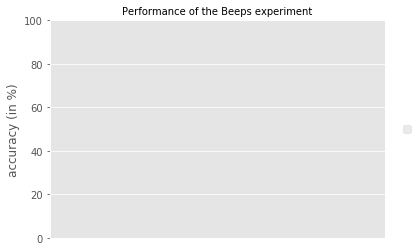

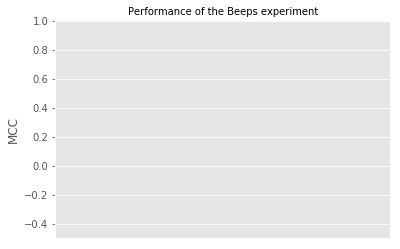

In [84]:
experiment = 'Beeps'
plotPerformace(results[experiment], experiment, saveFig = False, fltr = mccTreshold, comment = '', sort = 'preprocessing')

In [42]:
156+38

194